# DeepPoseKit Step 1 - Create an annotation set

This is step 1 of the example notebooks for using DeepPoseKit. This notebook shows you how to load and sample images from a video for labelling with keypoints.

If you haven't already installed DeepPoseKit and downloaded the example datasets you can run the next cell

In [4]:
!git clone https://github.com/jgraving/deepposekit-data

import sys
!{sys.executable} -m pip install \
git+https://github.com/jgraving/deepposekit \
git+https://github.com/jgraving/deepposekit-annotator

fatal: destination path 'deepposekit-data' already exists and is not an empty directory.
  Cloning https://github.com/jgraving/deepposekit-annotator to /private/var/folders/st/hhx75tj167g4qfsmb3rt8r7r0000gn/T/pip-req-build-xbqdzx3e
  Running command git clone -q https://github.com/jgraving/deepposekit-annotator /private/var/folders/st/hhx75tj167g4qfsmb3rt8r7r0000gn/T/pip-req-build-xbqdzx3e
  Cloning https://github.com/jgraving/deepposekit-annotator to /private/var/folders/st/hhx75tj167g4qfsmb3rt8r7r0000gn/T/pip-req-build-51iiyq46
  Running command git clone -q https://github.com/jgraving/deepposekit-annotator /private/var/folders/st/hhx75tj167g4qfsmb3rt8r7r0000gn/T/pip-req-build-51iiyq46
  Stored in directory: /private/var/folders/st/hhx75tj167g4qfsmb3rt8r7r0000gn/T/pip-ephem-wheel-cache-2r2s8zkc/wheels/0f/71/5b/0476551ba44d5d4e74da628c5bffdc210d6091bcd9a002e022
Successfully built dpk-annotator


In [16]:
import numpy as np
import cv2
import h5py
import matplotlib.pyplot as plt
from deepposekit import VideoReader, KMeansSampler
#from dpk_annotator import VideoReader, KMeansSampler
import tqdm
import glob

from os.path import expanduser
HOME = expanduser("~")

# A note on image resolutions

Currently DeepPoseKit only supports image resolutions that can be repeatedly divided by 2. For example, all of these values are valid image resolutions for either height or width:

In [17]:
exp = np.arange(1,12)
exp = 2**exp

print(1*exp)
print(3*exp)
print(5*exp)
print(7*exp)
print(11*exp)

[   2    4    8   16   32   64  128  256  512 1024 2048]
[   6   12   24   48   96  192  384  768 1536 3072 6144]
[   10    20    40    80   160   320   640  1280  2560  5120 10240]
[   14    28    56   112   224   448   896  1792  3584  7168 14336]
[   22    44    88   176   352   704  1408  2816  5632 11264 22528]


Images that do not match these resolutions must be manually resized, cropped, or padded. We are working to add automated image size adjustments.

# Open a video
The `VideoReader` class allows you to load in single video frames or batches of frames from nearly any video format.

In [21]:
# use glob to get the path(s) of the video(s)
videos = glob.glob(HOME + '/deepposekit-data/datasets/fly/*.avi')
videos

['/home/jake/deepposekit-data/datasets/fly/video.avi']

In [22]:
reader = VideoReader(videos[0], batch_size=100, gray=True)
frame = reader.read() # read a single frame
reader.close()

True

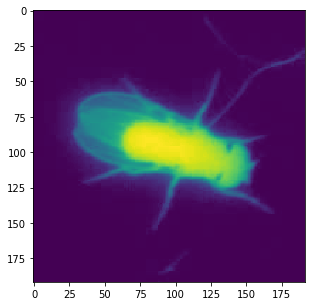

In [23]:
plt.figure(figsize=(5,5))
plt.imshow(frame[...,0])
plt.show()

# Save an image
You must save an image for initializing the annotation skeleton later

In [24]:
cv2.imwrite(HOME + '/deepposekit-data/datasets/fly/skeleton_image.png', frame)

True

# Sample video frames
Sample frames randomly from a video and hold them in memory

In [25]:
reader = VideoReader(videos[0], batch_size=100, gray=True)

sampled_frames = []
for idx in tqdm.tqdm(range(len(reader)-1)):
    batch = reader[idx]
    random_sample = batch[np.random.choice(batch.shape[0], 10, replace=False)]
    sampled_frames.append(random_sample)
reader.close()

sampled_frames = np.concatenate(sampled_frames)

100%|██████████| 337/337 [00:05<00:00, 61.91it/s]


# Apply k-means to reduce correlation

This applies the k-means algorithm to the images using the `KMeansSampler` class to even out sampling across the distribution of images and reduce correlation within the annotation set.

In [8]:
kmeans = KMeansSampler(n_clusters=10, max_iter=1000, n_init=10, batch_size=100, verbose=True)
kmeans.fit(sampled_frames)

Init 1/10 with method: k-means++
Inertia for init 1/10: 2467414077.443448
Init 2/10 with method: k-means++
Inertia for init 2/10: 2635702649.945322
Init 3/10 with method: k-means++
Inertia for init 3/10: 2762974714.236850
Init 4/10 with method: k-means++
Inertia for init 4/10: 2577831295.061691
Init 5/10 with method: k-means++
Inertia for init 5/10: 2539979447.352574
Init 6/10 with method: k-means++
Inertia for init 6/10: 2731048618.308717
Init 7/10 with method: k-means++
Inertia for init 7/10: 2691679891.446264
Init 8/10 with method: k-means++
Inertia for init 8/10: 2561577905.908879
Init 9/10 with method: k-means++
Inertia for init 9/10: 2513256598.454387
Init 10/10 with method: k-means++
Inertia for init 10/10: 2678277591.283096
Minibatch iteration 1/34000: mean batch inertia: 9710452.761211, ewa inertia: 9710452.761211 
Minibatch iteration 2/34000: mean batch inertia: 8887554.505025, ewa inertia: 9661630.556750 
Minibatch iteration 3/34000: mean batch inertia: 10118985.241945, ewa 

KMeansSampler(batch_size=100, compute_labels=True, init='k-means++',
       init_size=None, max_iter=1000, max_no_improvement=10, n_clusters=10,
       n_init=10, random_state=None, reassignment_ratio=0.01, tol=0.0,
       verbose=True)

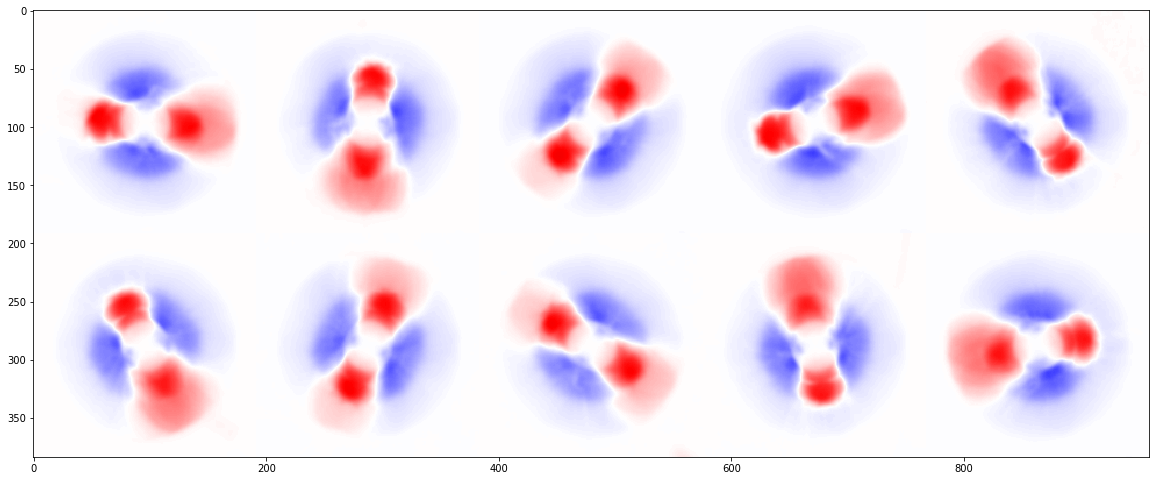

In [9]:
kmeans.plot_centers(n_rows=2)
plt.show()

In [10]:
images, labels = kmeans.sample_data(sampled_frames, n_samples_per_label=10)
images.shape

Computing label assignment and total inertia
Computing label assignment and total inertia


(100, 192, 192, 1)

# Save images to HDF5 file for annotations
You can use any method for sampling images to create a numpy array with the shape (n_images, height, width, channels) and then save to a HDF5 file using the next cell.

In [11]:
with h5py.File(HOME + '/deepposekit-data/datasets/fly/example_annotation_set.h5', mode='w') as h5file:
    h5file.create_dataset('images', shape=images.shape, dtype=np.uint8, data=images)

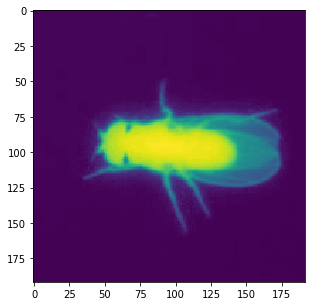

In [12]:
# Make sure the images are in the file
with h5py.File(HOME + '/deepposekit-data/datasets/fly/example_annotation_set.h5', mode='r') as h5file:
    h5image = h5file['images'][0]

plt.figure(figsize=(5,5))
plt.imshow(h5image[..., 0])

plt.show()

h5file.close()